https://gcdamp.com/images_gcdamp_com/7/7a/140619_FISH_IN_RIVER_GCDAMPwiki-_AZGF.PDF
https://www.fs.usda.gov/Internet/FSE_DOCUMENTS/fsbdev3_018622.pdf

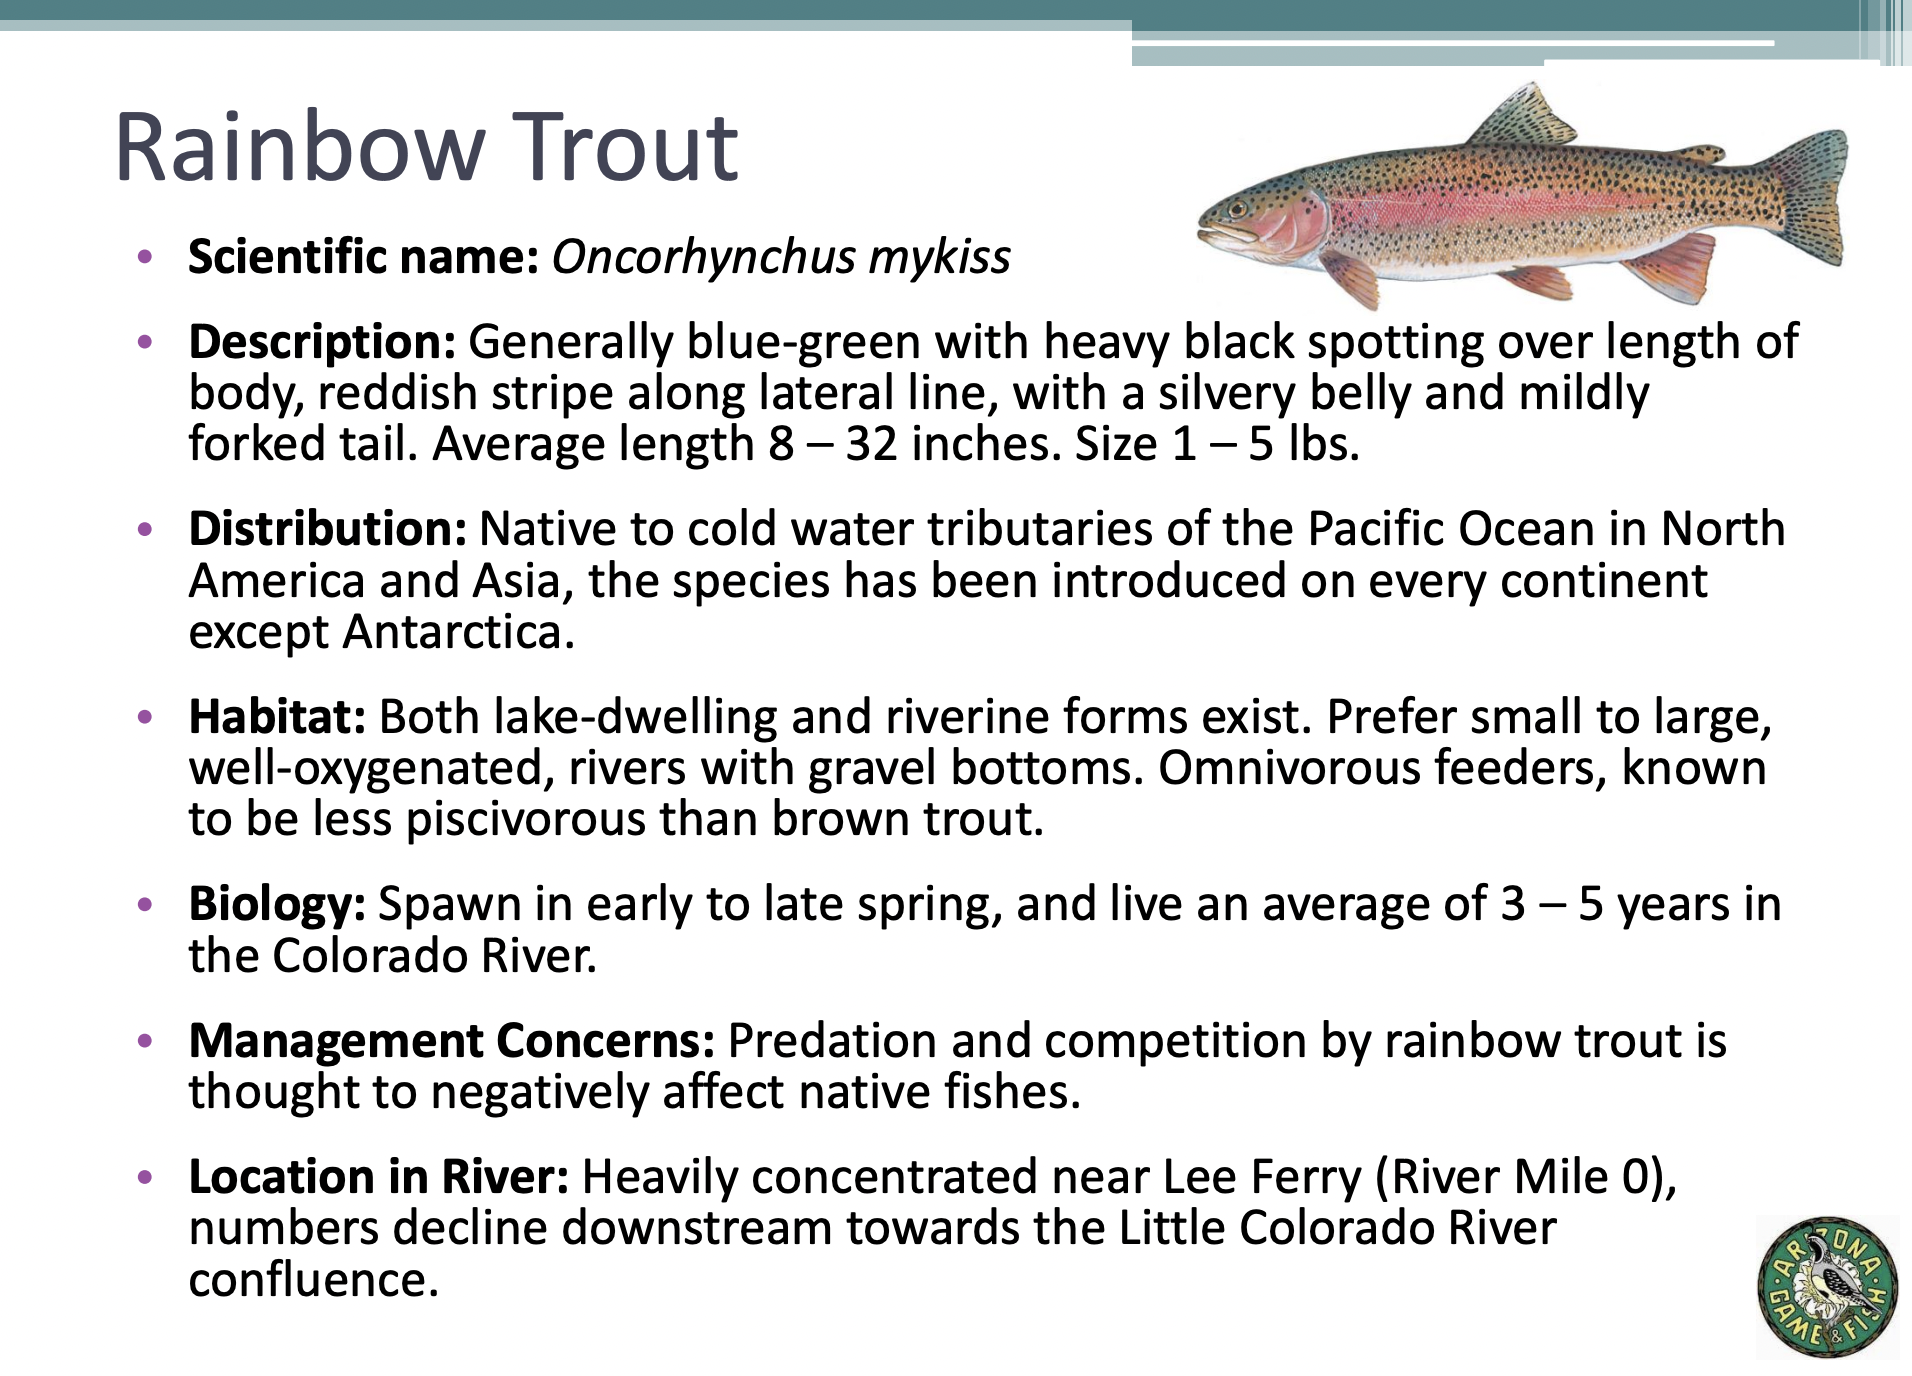

In [2]:
import numpy as np
import pandas as pd
import math
from scipy.optimize import minimize
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from ipywidgets import interactive

In [3]:
# Load data

#env_data = pd.read_excel("RainbowTrout_Growth_Data.xlsx", sheet_name = "Covariate_Data")

fish_data = pd.read_excel("RainbowTrout_Growth_Data.xlsx", sheet_name = "Growth_Data")

### Example 

In [5]:
# Sample data: Length at release (L1), Length at recapture (L2), and elapsed time (Delta_t)

data = {
    "L1": np.array([10, 15]),  # Length at release
    
    "L2": np.array([20, 25]),  # Length at recapture
    
    "Delta_t": np.array([1, 1.5])  # Time elapsed (years)
}

# Print data 

data

{'L1': array([10, 15]), 'L2': array([20, 25]), 'Delta_t': array([1. , 1.5])}

In [6]:
# Von Bertalanffy Growth Function to minimize

def vbgf(params, L1, L2, Delta_t):
    
    L_inf, k = params  # Extract parameters: L_infinity and k
    
    predicted_L2 = L_inf * (1 - np.exp(-k * Delta_t)) + L1 * np.exp(-k * Delta_t) # the Von Bertalanffy growth funtion 
    
    return np.sum((L2 - predicted_L2) ** 2)  # Sum of squared errors

In [7]:
# Initial guesses for L_inf and k
## These values are chosen based on prior knowledge or a reasonable assumption about the dataset.

initial_params = [30, 0.2]

# Optimize to find the best L_inf and k

result = minimize(vbgf, initial_params, args=(data["L1"], data["L2"], data["Delta_t"]), method='L-BFGS-B')

# Extract optimized parameters

L_inf, k = result.x

print(f"Optimized L_inf: {L_inf:.2f}, Optimized k: {k:.3f}")

Optimized L_inf: 31.29, Optimized k: 0.634


In [8]:
# Theoretical age estimation function

def calculate_age(L, L_inf, k, t0=0):
    
    """Estimate age based on length L using the rearranged von Bertalanffy equation."""
    
    age = t0 - np.log(1 - (L / L_inf)) / k
    
    return age

# Test age estimation

L_observed = 22  # Example observed length

age_estimated = calculate_age(L_observed, L_inf, k, t0=0)

print(f"Estimated age for length {L_observed}: {age_estimated:.2f} years")

Estimated age for length 22: 1.91 years


### Model Using Fish Data

#### Length Method

In [11]:
fish_data['Avg_Daily_Growth'] = fish_data['Length_Growth'] / fish_data['Time at Large'].replace(0, pd.NA)

In [12]:
# Determining daily constant growth term (K)

length_mean = fish_data['Avg_Daily_Growth'].mean()

length_median = fish_data['Avg_Daily_Growth'].median()

length_mode = fish_data['Avg_Daily_Growth'].mode()

print(f"Mean of daily length growth in the data is: {length_mean:.2f}")

print(f"Median of daily length growth in the data is: {length_median:.2f}")

print(f"Mean of daily length growth in the data is: {length_mode}")

Mean of daily length growth in the data is: 0.14
Median of daily length growth in the data is: 0.11
Mean of daily length growth in the data is: 0    0.0
Name: Avg_Daily_Growth, dtype: float64


In [13]:
model_data = fish_data[['Time at Large', 'Forklength at Release','Forklength at Recapture', 'Weight at Release', 'Weight at Recapture']]

In [14]:
model_data = model_data.dropna()

In [15]:
# Convert mm into cm

model_data.iloc[:,[1,2]] = model_data.iloc[:,[1,2]] / 10

# Convert days into "year"

model_data.iloc[:,[0]] = round(model_data.iloc[:,[0]] / 365,3)

/var/folders/0x/ry77ppt564g_7fms7vcmt7nw0000gn/T/ipykernel_10703/1785337853.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0       33.4
1       32.9
2       34.8
3       28.7
4       11.9
        ... 
9793    34.5
9794     9.5
9795    11.5
9796    15.7
9797    35.4
Name: Forklength at Recapture, Length: 9786, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  model_data.iloc[:,[1,2]] = model_data.iloc[:,[1,2]] / 10
/var/folders/0x/ry77ppt564g_7fms7vcmt7nw0000gn/T/ipykernel_10703/1785337853.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0       0.211
1       0.211
2       0.211
3       0.211
4       0.211
        ...  
9793    0.115
9794    0.115
9795    0.115
9796    0.115
9797    0.115
Name: Time at Large, Length: 9786, dtype: float64' has dtype incompatible with int64, please exp

In [16]:
model_data

,Time at Large,Forklength at Release,Forklength at Recapture,Weight at Release,Weight at Recapture
0,0.211,33.7,33.4,378.0,331.0
1,0.211,33.0,32.9,322.0,307.0
2,0.211,34.4,34.8,373.0,445.0
3,0.211,28.4,28.7,198.0,175.0
4,0.211,9.3,11.9,6.6,20.0
...,...,...,...,...,...
9793,0.115,35.0,34.5,493.0,458.0
9794,0.115,8.0,9.5,5.9,9.7
9795,0.115,8.5,11.5,7.9,21.4
9796,0.115,15.5,15.7,39.0,39.0


In [17]:
# Maximum length 

model_data['Forklength at Recapture'].max()

47.2

#### Model Construction

In [60]:
# Initialize with max possible length & average daily growth rate
## Online sources: max length 50.8 cm

initial_params = [47.2, 0.0143]

# Optimize to find the best L_inf and k

result = minimize(vbgf, initial_params, args=(model_data["Forklength at Release"], 
                                              model_data["Forklength at Recapture"],
                                              model_data["Time at Large"]),
                  method='L-BFGS-B')

# Extract optimized parameters

L_inf, k = result.x

print(f"Optimized L_inf: {L_inf:.2f}, Optimized k: {k:.3f}")

Optimized L_inf: 36.14, Optimized k: 0.421


In [62]:
# Calculate the final sum of squared errors using the optimized parameters

final_sse = result.fun  # The SSE is stored in the `fun` attribute of the result

print(f"Sum of Squared Errors (SSE): {final_sse:.2f}")

Sum of Squared Errors (SSE): 38094.31


In [21]:
# Average Individual Error 

38094.31 / 9786

3.8927355405681583

In [72]:
# Test age estimation

L_observed = 32.4  # Example observed length

age_estimated = calculate_age(L_observed, L_inf, k, t0=0)

print(f"Estimated age for length {L_observed} centimeters: {age_estimated:.2f} years")

Estimated age for length 32.4 centimeters: 5.39 years


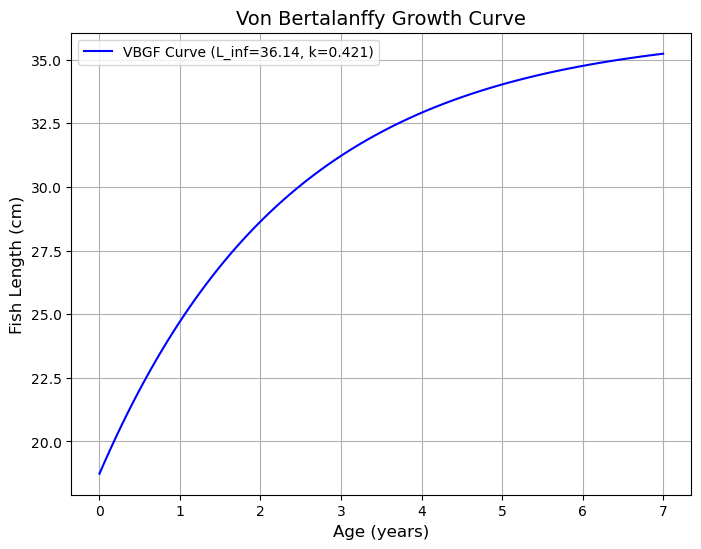

In [23]:
# Assuming L_inf and k are from the optimization result
L_inf, k = result.x  # Optimized parameters

# Initial fish length at release (mean of observed release lengths)
L0 = model_data["Forklength at Release"].mean()

# Generate time values in years 
# Maximal time a freshwater rainbow trout can live (8 years)

time_values_years = np.linspace(0, 7, 100)  # 0 to 8 years, 100 points

# Calculate predicted lengths using VBGF
predicted_lengths = L_inf * (1 - np.exp(-k * time_values_years)) + L0 * np.exp(-k * time_values_years)

# Plot the growth curve
plt.figure(figsize=(8, 6))
plt.plot(time_values_years, predicted_lengths, label=f'VBGF Curve (L_inf={L_inf:.2f}, k={k:.3f})', color='blue')

# Add labels, title, and legend
plt.title("Von Bertalanffy Growth Curve", fontsize=14)
plt.xlabel("Age (years)", fontsize=12)  # Time in years
plt.ylabel("Fish Length (cm)", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

In [136]:
27.5+1.25

(31.25-28.75)/12

(0.31-0.21)/0.31

(2.08-0.21)/2.08

0.8990384615384616

The model suggests that in first year of life of trouts' from the lower basin of Colorado River, they are likely to grow at a rate of 2.08 cm a month, which is about 0.81 inches. This estimation of growth rate is reasonable as various online sources also suggest that, trouts can grow at a rate of 1 inch each month, given the ideal water temperature (warmer), adequate feeding, and selective breeding practices done by humans.

Note, that the annual average water temperature of the lower basin of colorado river is around 56 F, which is about 13 C. At this tempearture, a relative high tempeature for trouts, is condusive to their growth assuming sufficiency of food.

In their second year, the growth in length is less rapid than in their first year of life, averaging just 0.31 cm (0.12 inches) per month. This represents an 85% reduction in monthly growth compared to the first year. 

In their third year, the growth rate slows even further, averaging approximately 0.21 cm (0.08 inches) per month. This reflects a 32% decrease in monthly growth compared to the second year and an 89% reduction compared to the first year. After year three, the trouts grows at a rate around 2.54 cm (1 inch) a year. Additionally, rainbow trouts becomes sexually mature after their third year of life. 

_Sources_: 
1. https://www.arcgis.com/apps/dashboards/25cc87de162e480991a93fc49c1fea4b
2. https://forums.pondboss.com/ubbthreads.php?ubb=showflat&Number=340588 
3. https://www.utahwildlife.net/threads/trout-growth-per-year.1146/ 

#### Weight Method

In [25]:
fish_data['Avg_Daily_WGrowth'] = fish_data['Weight_Growth'] / fish_data['Time at Large'].replace(0, pd.NA)

In [26]:
# Determining daily constant growth term (K)

weight_mean = fish_data['Avg_Daily_WGrowth'].mean()

weight_median = fish_data['Avg_Daily_WGrowth'].median()

weight_mode = fish_data['Avg_Daily_WGrowth'].mode()

print(f"Mean of daily length growth in the data is: {weight_mean:.2f}")

print(f"Median of daily length growth in the data is: {weight_median:.2f}")

print(f"Mean of daily length growth in the data is: {weight_mode}")

Mean of daily length growth in the data is: 0.10
Median of daily length growth in the data is: 0.11
Mean of daily length growth in the data is: 0    0.0
Name: Avg_Daily_WGrowth, dtype: float64


In [27]:
# Maximum length 

model_data['Weight at Recapture'].max()

1265.0

#### Model Construction

In [76]:
# Initialize with max possible weight & average weight daily growth rate

initial_params = [1265.0, 0.010]

# Optimize to find the best w_inf and k

result = minimize(vbgf, initial_params, args=(model_data["Weight at Release"], 
                                              model_data["Weight at Recapture"],
                                              model_data["Time at Large"]),
                  method='L-BFGS-B')

# Extract optimized parameters

w_inf, k = result.x

print(f"Optimized L_inf: {w_inf:.2f}, Optimized k: {k:.3f}")

Optimized L_inf: 1265.00, Optimized k: 0.073


In [78]:
# Calculate the final sum of squared errors using the optimized parameters
final_sse = result.fun  # The SSE is stored in the `fun` attribute of the result

print(f"Sum of Squared Errors (SSE): {final_sse:.2f}")

Sum of Squared Errors (SSE): 35757497.71


In [31]:
# Average Individual Error 

math.sqrt(35757497.71)

5979.75732868818

In [80]:
# Test age estimation

W_observed = 20  # Example observed length

age_estimated = calculate_age(W_observed, w_inf, k, t0=0)

print(f"Estimated age for weight {W_observed} grams: {age_estimated:.2f} years")

Estimated age for weight 20 grams: 0.22 years


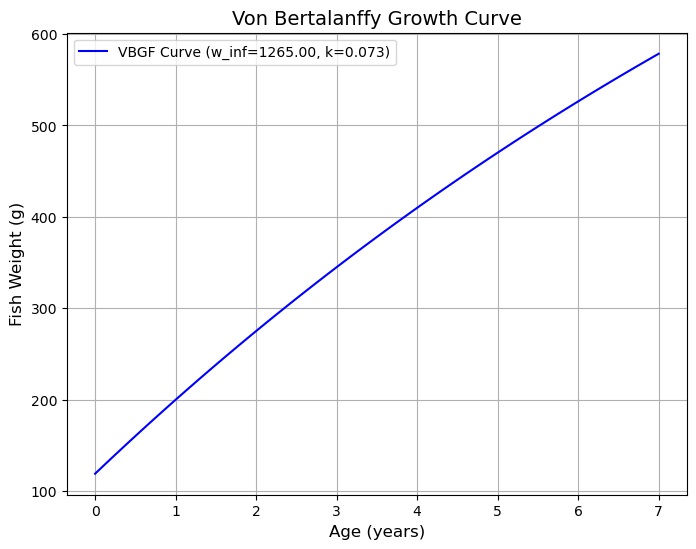

In [139]:
# Assuming L_inf and k are from the optimization result
w_inf, k = result.x  # Optimized parameters

# Initial fish length at release (mean of observed release lengths)
L0 = model_data["Weight at Release"].mean()

# Generate time values in years 
# Maximal time a freshwater rainbow trout can live (8 years)

time_values_years = np.linspace(0, 7, 100)  # 0 to 8 years, 100 points

# Calculate predicted lengths using VBGF
predicted_lengths = w_inf * (1 - np.exp(-k * time_values_years)) + L0 * np.exp(-k * time_values_years)

# Plot the growth curve
plt.figure(figsize=(8, 6))
plt.plot(time_values_years, predicted_lengths, label=f'VBGF Curve (w_inf={w_inf:.2f}, k={k:.3f})', color='blue')

# Add labels, title, and legend
plt.title("Von Bertalanffy Growth Curve", fontsize=14)
plt.xlabel("Age (years)", fontsize=12)  # Time in years
plt.ylabel("Fish Weight (g)", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()